In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import time
import requests
import seaborn as sns
from sqlalchemy import create_engine  # For database connection
from config import db_username, db_password, db_host, db_port, db_name # Database credentials

import plotly.express as px
from shapely import wkb
import geopandas as gpd               # For geospatial data processing

# Suppress warnings for better readability of the output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Create connection string
connection_string = f'postgresql://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}'
# Create SQLAlchemy engine
engine = create_engine(connection_string)

In [3]:
# SQL query to number of businesses (by borough) for testing Ville-Marie NUM 20
query_boroughs = """
        SELECT * FROM public.boroughs;
"""

In [4]:
# Executing the query for buisnesses calculation and storing the result in a DataFrame
boroughs = pd.read_sql(query_boroughs, engine)

# Display the population density data
boroughs.head(3)

,CODEID,NOM,NOM_OFFICI,CODEMAMH,CODE_3C,NUM,ABREV,TYPE,COMMENT,DATEMODIF,geometry
0,0,Montreal island,Montreal island,MIS,MIS,0,MI,City,produced and named by Reiner Braun,2025-03-27,0103000020E61000000100000006060000E4A909843C75...
1,34,Anjou,Anjou,REM09,ANJ,9,AJ,Arrondissement,None,2022-08-24,0103000020E61000000100000028020000060A02DA9966...
2,33,Pointe-Claire,Pointe-Claire,66097,PCL,8,PC,Ville liée,None,2022-08-24,0103000020E610000001000000CD01000025EDB7892E71...


In [5]:
# String1 = 'https://restapi.frankfurtskreative.de'
String1 = 'http://192.168.178.24:5000'

### Read the scenarios defined in the scenarios file

In [6]:
response = requests.get(String1 + '/scenarios')

In [7]:
response.json()

{'food_security': ['food_stores', 'interactive_scenario', 'base']}

In [8]:
response = requests.post(
    url=f'{String1}/equations',
    json = {
    "scenarioManager": "food_security",
    "scenario":"base"
}
)

In [9]:
# Show the constants, converters, flows and stocks in the model. All the parameters you can see here can be queried.
parameters = response.json()
# parameters

In [10]:
# Combine converters and stocks into one equations list
equations_list = parameters['converters'] + parameters['stocks']
print(equations_list)

['immigrationStatusRisk', 'localMarketPressure', 'openingHoursOfSupermarketsDailyStoresRestaurants', 'initialNumberOfUrbanFarms', 'publicTransportDensity', 'urbanFoodProductionDeveloment', 'coeffSimple', 'householdFoodInsecuritySimple', 'residentialOrGeographicalSegregation', 'initialSingleParent', 'interceptSimple', 'cSingleParent', 'cNonImmigrants', 'supermarketAndHealthyFoodStoreDevelopment', 'initialNumberOfSupermarkets', 'initialNonPermanentResidents', 'negativePerceptionsOfLocalArea', 'situationalOrTimeConstraints', 'insufficientFoodBudget', 'initialImmigrants', 'cImmigrants', 'initialTwoParent', 'outletClosing', 'optimalProductionDensity', 'newBuildRatePublicTransport', 'initialSinglePersonLivingAlone', 'cityRate', 'fastFoodOutletDevelopment', 'initialSubsidizedHousing', 'initialCoupleWithoutChildren', 'healthDeterminedPurchases', 'initialGini', 'cSinglePersonLivingAlone', 'cOwner', 'intercept', 'costOfLiving', 'costOfPublicTransport', 'objectiveRelativeCostOfHealthyFood', 'init

In [11]:
# Geographical Access
# supermarketAndHealthyFoodStoreDevelopment
# fastFoodOutletDevelopment
# urbanFoodProductionDeveloment 

# KPI's for food insecurity
# accessibilityOfHealthyFoodInLocalArea
# availabilityOfHealthyFoodInLocalArea
# householdFoodInsecurity

# fastFoodOutletDensity
# householdFoodInsecuritySimple'

# insufficientFoodBudget

# healthDeterminedPurchases
# objectiveRelativeCostOfHealthyFood
# availabilityOfHealthyFoodInLocalArea
# vulnerabilityToFluctuationInLivingCosts
# automaticVendingMachinesDevelopment
# needToShopOutsideLocality
# publicTransportStationDevelopment
# pressureOnPolicyForPublicTransportDevelopment
# financialManagement
# populationGrowth
# availabilityOfHealthyFoodInHousehold
# perceptionAsCapativeCustomerInLocalArea
# willingnessToPayForHealthyFoods
# strategicUnhealthyEatingHabits
# propotionOfIncomeOnFoodBudget
# perceivedAffordabilityOfHealthyFood
# accessibilityAndAffordabilityOfPublicTransport
# customerDemandForHealthyFood
# supermarketAndHealthyFoodStoreDensity
# productionDensity


# 'delayUnhealthyEating'
# 'delayHabit'


In [12]:
# List of NUM values to loop over
# NUM_list = [2, 4, 24, 9, 72, 27, 11, 1, 6, 17, 14, 15, 18, 23, 16, 5, 8, 22, 13, 25, 19, 21, 12, 20, 26] #74, 3,  10, 73, 75, 76, 77, 7, 71, 

NUM_list = [24, 9, 72, 27, 1, 18, 17, 22, 21, 23, 11, 2, 16, 5, 13, 8, 19, 25, 15, 14, 12, 20, 26, 4] #74, 
# NUM_list = [20, 24] #74, 
results = []

for NUM in NUM_list:
    # POST request to write the scenario with the current NUM
    res = requests.post(
        url=f'{String1}/write_scenario',
        json=f'{{"city": "Montreal", "borough_name": "Ville-Marie", "NUM": {NUM}, \
        "newBuildRateSupermarketAndHealthyFoodStore": 2, \
        "newBuildRateFastFoodOutlet": 20, \
        "newBuildRatePublicTransport": 0.2, \
        "newBuildRateUrbanFarms": 0.2, \
        "timeToAdjustCostsOfPublicTransport": 1, \
        "optimalTransportStationDensity": 50}}'
    )
    
    # Pause for 1 second between requests
    time.sleep(1)
    
    # POST request to run the scenario, now using the equations from the parameters JSON
    response = requests.post(
        url=String1 + '/run',
        json={
            "scenario_managers": ["food_security"],
            "scenarios": ["base"],
            "equations": equations_list
        }
    )
    
    # Extract the equations results from the response
    data = response.json()['food_security']['base']['equations']
    
    # Build a result entry starting with the current NUM
    entry = {"NUM": NUM}
    # Loop over each equation in the combined list and add it to the entry
    for eq in equations_list:
        entry[eq] = data.get(eq)  # you can use .get() to safely retrieve the value
    
    results.append(entry)

# Create a DataFrame from the results list
df = pd.DataFrame(results)
# print(df)

In [13]:
results_geometry = pd.merge(df,boroughs,how='inner',on='NUM')
results_geometry.head(5)

,NUM,immigrationStatusRisk,localMarketPressure,openingHoursOfSupermarketsDailyStoresRestaurants,initialNumberOfUrbanFarms,publicTransportDensity,urbanFoodProductionDeveloment,coeffSimple,householdFoodInsecuritySimple,residentialOrGeographicalSegregation,...,CODEID,NOM,NOM_OFFICI,CODEMAMH,CODE_3C,ABREV,TYPE,COMMENT,DATEMODIF,geometry
0,24,"{'0.0': 0.04908837292760279, '1.0': 0.04908837...","{'0.0': 0.9119811750650022, '1.0': 0.920970444...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....","{'0.0': 0.0, '1.0': 0.0, '2.0': 0.0, '3.0': 0....","{'0.0': 27.08147508320586, '1.0': 27.082864408...","{'0.0': 0.19998927368574315, '1.0': 0.19998607...","{'0.0': 1.0, '1.0': 1.0, '2.0': 1.0, '3.0': 1....","{'0.0': 0.11128368603229179, '1.0': 0.11128368...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....",...,17,Ahuntsic-Cartierville,Ahuntsic-Cartierville,REM23,AHU,AC,Arrondissement,None,2022-08-24,0103000020E610000001000000480800004C8FA54EE070...
1,9,"{'0.0': 0.09119488034867995, '1.0': 0.09119488...","{'0.0': 0.9598754896866583, '1.0': 0.990853973...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....","{'0.0': 0.0, '1.0': 0.0, '2.0': 0.0, '3.0': 0....","{'0.0': 21.153443519610388, '1.0': 21.15998628...","{'0.0': 0.19996505290620223, '1.0': 0.19989931...","{'0.0': 1.0, '1.0': 1.0, '2.0': 1.0, '3.0': 1....","{'0.0': 0.15121284118867423, '1.0': 0.15121284...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....",...,34,Anjou,Anjou,REM09,ANJ,AJ,Arrondissement,None,2022-08-24,0103000020E61000000100000028020000060A02DA9966...
2,72,"{'0.0': 0.11697823936158161, '1.0': 0.11697823...","{'0.0': 0.955752065342777, '1.0': 0.9969912805...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....","{'0.0': 0.0, '1.0': 0.0, '2.0': 0.0, '3.0': 0....","{'0.0': 17.344347642068275, '1.0': 17.36029114...","{'0.0': 0.1995985726194853, '1.0': 0.198738211...","{'0.0': 1.0, '1.0': 1.0, '2.0': 1.0, '3.0': 1....","{'0.0': 0.1752229015189142, '1.0': 0.175222901...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....",...,27,Côte-Saint-Luc,Côte-Saint-Luc,66058,CSL,CL,Ville liée,None,2022-08-24,0106000020E6100000030000000103000000010000009A...
3,27,"{'0.0': 0.05194882025567815, '1.0': 0.05194882...","{'0.0': 0.9865250609426317, '1.0': 0.990337491...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....","{'0.0': 0.0, '1.0': 0.0, '2.0': 0.0, '3.0': 0....","{'0.0': 28.34288499863713, '1.0': 28.345273558...","{'0.0': 0.19973145009796653, '1.0': 0.19969357...","{'0.0': 1.0, '1.0': 1.0, '2.0': 1.0, '3.0': 1....","{'0.0': 0.12179397105499647, '1.0': 0.12179397...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....",...,20,Côte-des-Neiges-Notre-Dame-de-Grâce,Côte-des-Neiges–Notre-Dame-de-Grâce,REM34,CDN,CN,Arrondissement,Il est important de noter que la limite située...,2022-08-24,0103000020E6100000010000007B050000159007D43E69...
4,1,"{'0.0': 0.15375501863682658, '1.0': 0.15375501...","{'0.0': 0.9997649139921609, '1.0': 0.999764856...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....","{'0.0': 0.0, '1.0': 0.0, '2.0': 0.0, '3.0': 0....","{'0.0': 11.757996944181695, '1.0': 11.76440294...","{'0.0': 0.1998119520557482, '1.0': 0.199811893...","{'0.0': 1.0, '1.0': 1.0, '2.0': 1.0, '3.0': 1....","{'0.0': 0.2026542530728735, '1.0': 0.202654253...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....",...,1,Dorval,Dorval,66087,DOR,DV,Ville liée,None,2022-08-24,0103000020E6100000020000009B01000025EDB7892E71...


In [14]:
df.head(3)

,NUM,immigrationStatusRisk,localMarketPressure,openingHoursOfSupermarketsDailyStoresRestaurants,initialNumberOfUrbanFarms,publicTransportDensity,urbanFoodProductionDeveloment,coeffSimple,householdFoodInsecuritySimple,residentialOrGeographicalSegregation,...,newBuildRateSupermarketAndHealthyFoodStore,newBuildRateFastFoodOutlet,crimeRate,delayHabit,rentalCost,numberOfAutomaticVendingMachines,numberOfPublicTransportStations,numberOfSupermaketsAndHealthyFoodStore,numberOfUrbanFarms,numberOfFastFoodOutlet
0,24,"{'0.0': 0.04908837292760279, '1.0': 0.04908837...","{'0.0': 0.9119811750650022, '1.0': 0.920970444...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....","{'0.0': 0.0, '1.0': 0.0, '2.0': 0.0, '3.0': 0....","{'0.0': 27.08147508320586, '1.0': 27.082864408...","{'0.0': 0.19998927368574315, '1.0': 0.19998607...","{'0.0': 1.0, '1.0': 1.0, '2.0': 1.0, '3.0': 1....","{'0.0': 0.11128368603229179, '1.0': 0.11128368...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....",...,"{'0.0': 2, '1.0': 2, '2.0': 2, '3.0': 2, '4.0'...","{'0.0': 20, '1.0': 20, '2.0': 20, '3.0': 20, '...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....","{'0.0': 4.0, '1.0': 4.0, '2.0': 4.0, '3.0': 4....","{'0.0': 10.0, '1.0': 10.0, '2.0': 10.0, '3.0':...","{'0.0': 0.0, '1.0': -2.0, '2.0': -4.0, '3.0': ...","{'0.0': 658.1, '1.0': 658.1337616413108, '2.0'...","{'0.0': 195.1, '1.0': 195.1, '2.0': 195.1, '3....","{'0.0': 0.0, '1.0': 0.19998927368574315, '2.0'...","{'0.0': 241.1, '1.0': 261.1, '2.0': 281.1, '3...."
1,9,"{'0.0': 0.09119488034867995, '1.0': 0.09119488...","{'0.0': 0.9598754896866583, '1.0': 0.990853973...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....","{'0.0': 0.0, '1.0': 0.0, '2.0': 0.0, '3.0': 0....","{'0.0': 21.153443519610388, '1.0': 21.15998628...","{'0.0': 0.19996505290620223, '1.0': 0.19989931...","{'0.0': 1.0, '1.0': 1.0, '2.0': 1.0, '3.0': 1....","{'0.0': 0.15121284118867423, '1.0': 0.15121284...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....",...,"{'0.0': 2, '1.0': 2, '2.0': 2, '3.0': 2, '4.0'...","{'0.0': 20, '1.0': 20, '2.0': 20, '3.0': 20, '...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....","{'0.0': 4.0, '1.0': 4.0, '2.0': 4.0, '3.0': 4....","{'0.0': 10.0, '1.0': 10.0, '2.0': 10.0, '3.0':...","{'0.0': 0.0, '1.0': -2.0, '2.0': -4.0, '3.0': ...","{'0.0': 291.1, '1.0': 291.19003737091174, '2.0...","{'0.0': 47.1, '1.0': 47.1, '2.0': 47.1, '3.0':...","{'0.0': 0.0, '1.0': 0.19996505290620223, '2.0'...","{'0.0': 64.1, '1.0': 84.1, '2.0': 104.1, '3.0'..."
2,72,"{'0.0': 0.11697823936158161, '1.0': 0.11697823...","{'0.0': 0.955752065342777, '1.0': 0.9969912805...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....","{'0.0': 0.0, '1.0': 0.0, '2.0': 0.0, '3.0': 0....","{'0.0': 17.344347642068275, '1.0': 17.36029114...","{'0.0': 0.1995985726194853, '1.0': 0.198738211...","{'0.0': 1.0, '1.0': 1.0, '2.0': 1.0, '3.0': 1....","{'0.0': 0.1752229015189142, '1.0': 0.175222901...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....",...,"{'0.0': 2, '1.0': 2, '2.0': 2, '3.0': 2, '4.0'...","{'0.0': 20, '1.0': 20, '2.0': 20, '3.0': 20, '...","{'0.0': 0.5, '1.0': 0.5, '2.0': 0.5, '3.0': 0....","{'0.0': 4.0, '1.0': 4.0, '2.0': 4.0, '3.0': 4....","{'0.0': 10.0, '1.0': 10.0, '2.0': 10.0, '3.0':...","{'0.0': 0.0, '1.0': -2.0, '2.0': -4.0, '3.0': ...","{'0.0': 118.1, '1.0': 118.20856147483765, '2.0...","{'0.0': 15.1, '1.0': 15.1, '2.0': 15.1, '3.0':...","{'0.0': 0.0, '1.0': 0.1995985726194853, '2.0':...","{'0.0': 11.1, '1.0': 31.1, '2.0': 51.1, '3.0':..."


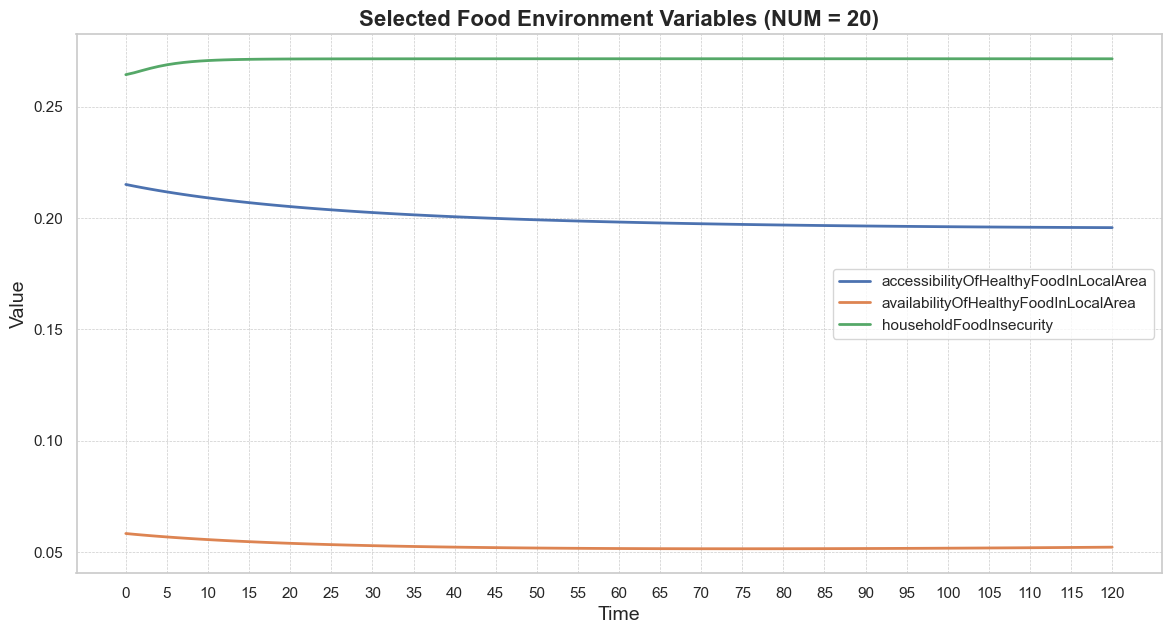

In [15]:
# Set seaborn style
sns.set(style="whitegrid")

# Define the variables you want to plot
variables_to_plot = [
    'accessibilityOfHealthyFoodInLocalArea',
    'availabilityOfHealthyFoodInLocalArea',
    'householdFoodInsecurity'
]

# Filter the DataFrame for NUM == 20
df_num_20 = df[df['NUM'] == 20]

# Safety check
if df_num_20.empty:
    raise ValueError("No row with NUM == 20 found in the DataFrame.")

# Get the single row
row = df_num_20.iloc[0]

# Set up the plot
plt.figure(figsize=(14, 7))

# Loop through each selected variable
for var in variables_to_plot:
    # Convert the JSON-like dict string into a DataFrame
    series = pd.DataFrame.from_dict(
        pd.json_normalize(row[var]), orient='columns'
    ).T.reset_index(drop=True)
    
    # Plot the values
    plt.plot(
        series.index,
        series.values.flatten(),
        label=var,
        linewidth=2
    )

# Customize the plot
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Selected Food Environment Variables (NUM = 20)', fontsize=16, weight='bold')
plt.xticks(ticks=range(0, series.shape[0], 5))  # Adjust tick interval as needed
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)

# Save and show the plot
plt.savefig('Figures/selected_food_env_variables_NUM_20.png', dpi=300, bbox_inches='tight')
plt.show()


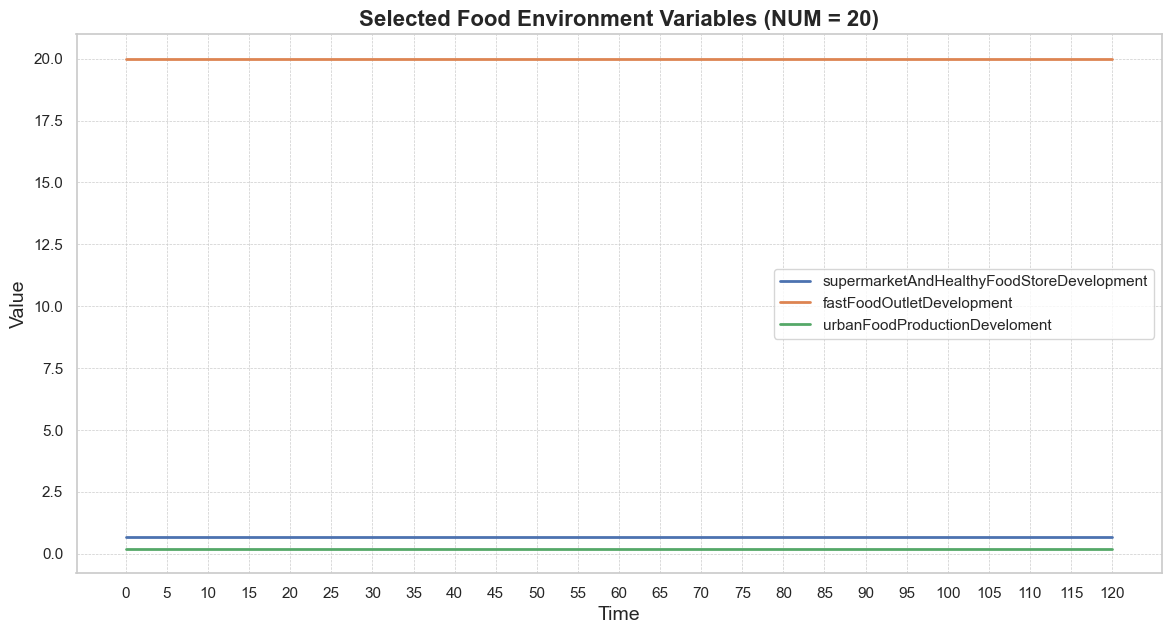

In [16]:
# Set seaborn style
sns.set(style="whitegrid")

# Define the variables you want to plot
variables_to_plot = [
    'supermarketAndHealthyFoodStoreDevelopment',
    'fastFoodOutletDevelopment',
    'urbanFoodProductionDeveloment'
]

# Filter the DataFrame for NUM == 20
df_num_20 = df[df['NUM'] == 20]

# Safety check
if df_num_20.empty:
    raise ValueError("No row with NUM == 20 found in the DataFrame.")

# Get the single row
row = df_num_20.iloc[0]

# Set up the plot
plt.figure(figsize=(14, 7))

# Loop through each selected variable
for var in variables_to_plot:
    # Convert the JSON-like dict string into a DataFrame
    series = pd.DataFrame.from_dict(
        pd.json_normalize(row[var]), orient='columns'
    ).T.reset_index(drop=True)
    
    # Plot the values
    plt.plot(
        series.index,
        series.values.flatten(),
        label=var,
        linewidth=2
    )

# Customize the plot
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Selected Food Environment Variables (NUM = 20)', fontsize=16, weight='bold')
plt.xticks(ticks=range(0, series.shape[0], 5))  # Adjust tick interval as needed
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)

# Save and show the plot
plt.savefig('Figures/selected_food_env_variables_NUM_20.png', dpi=300, bbox_inches='tight')
plt.show()

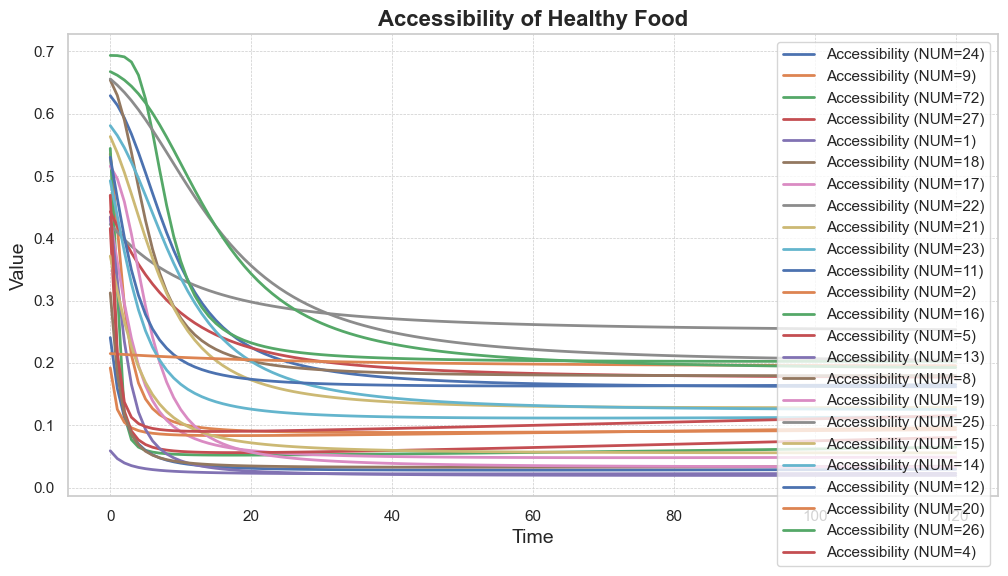

In [17]:
# Use seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Loop over each row in the DataFrame, where each row corresponds to a different NUM
for idx, row in df.iterrows():
    NUM_val = row['NUM']
    
    # Convert the JSON output for accessibility into a DataFrame and reset the index
    df_accessibility = pd.DataFrame.from_dict(
        pd.json_normalize(row['accessibilityOfHealthyFoodInLocalArea']), 
        orient='columns'
    ).T.reset_index(drop=True)
    
    # Plot the accessibility time series for this NUM.
    plt.plot(
        df_accessibility.index, 
        df_accessibility.values.flatten(), 
        label=f'Accessibility (NUM={NUM_val})',
        linestyle='-', 
        linewidth=2
    )

# Set x-axis ticks; adjust the step if needed.
plt.xticks(ticks=range(0, len(df_accessibility.index), 20))
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Accessibility of Healthy Food', fontsize=16, weight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a PNG file
plt.savefig('Figures/accessibility_only.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

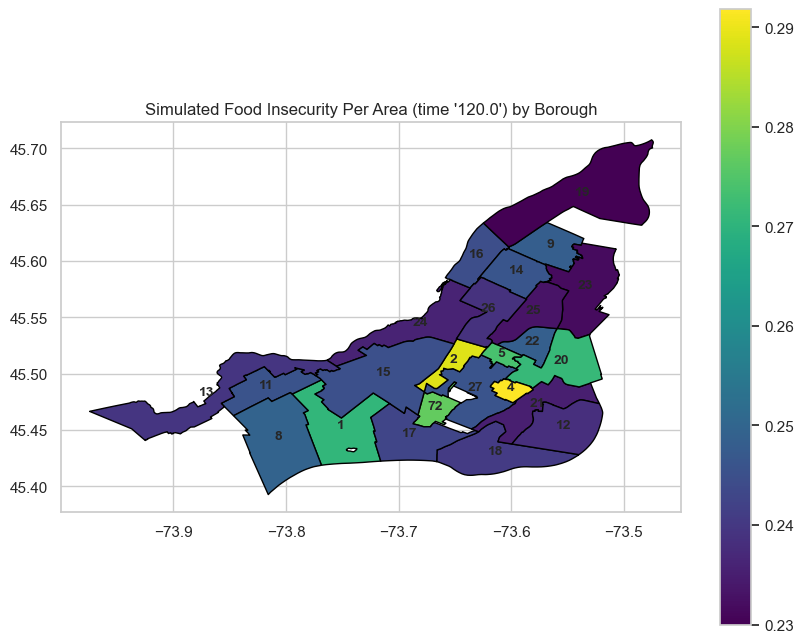

In [18]:
# Function to convert hex-encoded WKB to a shapely geometry object
def convert_wkb(hex_str):
    return wkb.loads(bytes.fromhex(hex_str))

# --- Assume df is your DataFrame as shown above ---

# 1. Convert the 'geometry' column from WKB hex to shapely geometries
results_geometry['geometry'] = results_geometry['geometry'].apply(convert_wkb)

# 2. Create a new column 'popGrowth' that extracts the value for time "0.0"
results_geometry['results'] = results_geometry['householdFoodInsecurity'].apply(lambda d: d.get('120.0') if isinstance(d, dict) else None)

# 3. Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(results_geometry, geometry='geometry')

# 4. Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='results', ax=ax, legend=True, cmap='viridis', edgecolor='black')

# 5. Annotate each feature with its NUM value at the centroid of its geometry
for idx, row in gdf.iterrows():
    # Compute the centroid coordinates
    centroid = row['geometry'].centroid
    ax.annotate(text=str(row['NUM']), xy=(centroid.x, centroid.y),
                horizontalalignment='center', fontsize=10, fontweight='bold')

plt.title("Simulated Food Insecurity Per Area (time '120.0') by Borough")

# Save the plot as a PNG file
plt.savefig('Figures/initialFoodInsecurity_map.png', dpi=300, bbox_inches='tight')
plt.show()

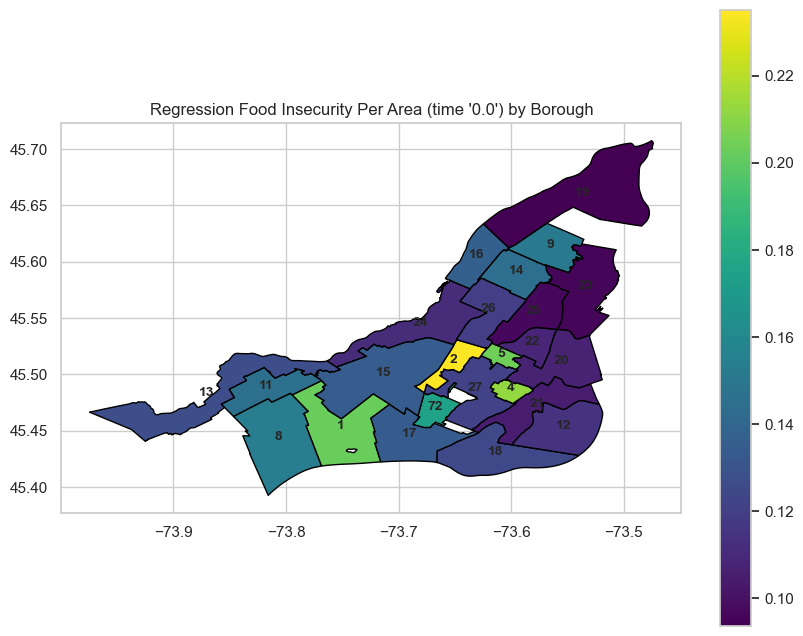

In [19]:
# Function to convert hex-encoded WKB to a shapely geometry object
def convert_wkb(hex_str):
    return wkb.loads(bytes.fromhex(hex_str))

# --- Assume df is your DataFrame as shown above ---

# # 1. Convert the 'geometry' column from WKB hex to shapely geometries
# results_geometry['geometry'] = results_geometry['geometry'].apply(convert_wkb)

# 2. Create a new column 'popGrowth' that extracts the value for time "0.0"
results_geometry['results'] = results_geometry['householdFoodInsecuritySimple'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)

# 3. Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(results_geometry, geometry='geometry')

# 4. Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='results', ax=ax, legend=True, cmap='viridis', edgecolor='black')

# 5. Annotate each feature with its NUM value at the centroid of its geometry
for idx, row in gdf.iterrows():
    # Compute the centroid coordinates
    centroid = row['geometry'].centroid
    ax.annotate(text=str(row['NUM']), xy=(centroid.x, centroid.y),
                horizontalalignment='center', fontsize=10, fontweight='bold')

plt.title("Regression Food Insecurity Per Area (time '0.0') by Borough")

# Save the plot as a PNG file
plt.savefig('Figures/initialavailabilityOfHealthyFoodInLocalArea_map.png', dpi=300, bbox_inches='tight')
plt.show()

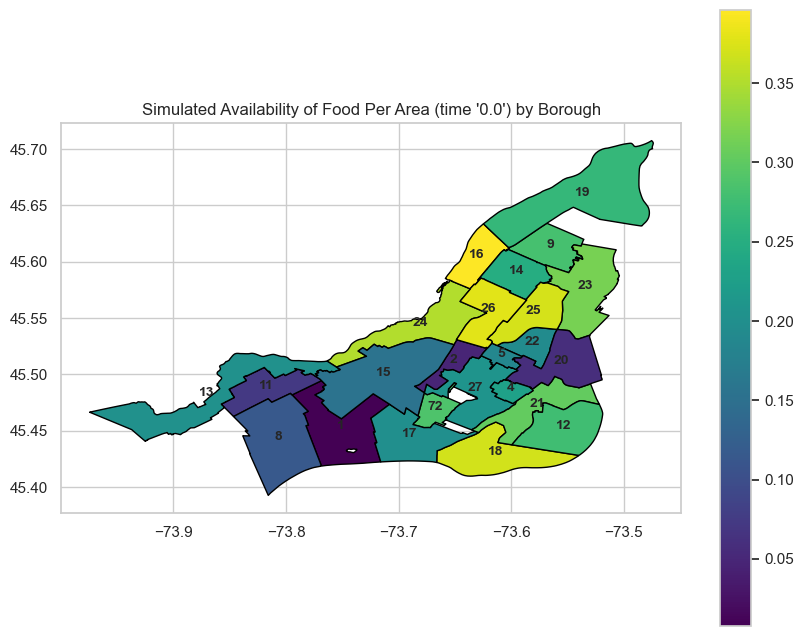

In [20]:
# Function to convert hex-encoded WKB to a shapely geometry object
def convert_wkb(hex_str):
    return wkb.loads(bytes.fromhex(hex_str))

# --- Assume df is your DataFrame as shown above ---

# # 1. Convert the 'geometry' column from WKB hex to shapely geometries
# results_geometry['geometry'] = results_geometry['geometry'].apply(convert_wkb)

# 2. Create a new column 'popGrowth' that extracts the value for time "0.0"
results_geometry['results'] = results_geometry['availabilityOfHealthyFoodInLocalArea'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)

# 3. Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(results_geometry, geometry='geometry')

# 4. Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='results', ax=ax, legend=True, cmap='viridis', edgecolor='black')

# 5. Annotate each feature with its NUM value at the centroid of its geometry
for idx, row in gdf.iterrows():
    # Compute the centroid coordinates
    centroid = row['geometry'].centroid
    ax.annotate(text=str(row['NUM']), xy=(centroid.x, centroid.y),
                horizontalalignment='center', fontsize=10, fontweight='bold')

plt.title("Simulated Availability of Food Per Area (time '0.0') by Borough")

# Save the plot as a PNG file
plt.savefig('Figures/initialavailabilityOfHealthyFoodInLocalArea_map.png', dpi=300, bbox_inches='tight')
plt.show()

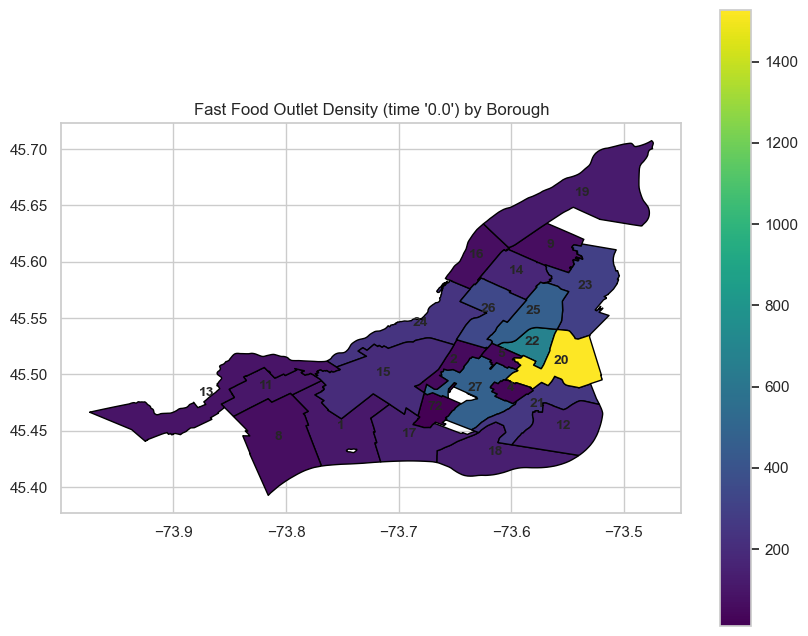

In [21]:
# Function to convert hex-encoded WKB to a shapely geometry object
def convert_wkb(hex_str):
    return wkb.loads(bytes.fromhex(hex_str))

# --- Assume df is your DataFrame as shown above ---

# # 1. Convert the 'geometry' column from WKB hex to shapely geometries
# results_geometry['geometry'] = results_geometry['geometry'].apply(convert_wkb)

# 2. Create a new column 'popGrowth' that extracts the value for time "0.0"
results_geometry['results'] = results_geometry['initialNumberOfFastFoodOutlet'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)

# 3. Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(results_geometry, geometry='geometry')

# 4. Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='results', ax=ax, legend=True, cmap='viridis', edgecolor='black')

# 5. Annotate each feature with its NUM value at the centroid of its geometry
for idx, row in gdf.iterrows():
    # Compute the centroid coordinates
    centroid = row['geometry'].centroid
    ax.annotate(text=str(row['NUM']), xy=(centroid.x, centroid.y),
                horizontalalignment='center', fontsize=10, fontweight='bold')

plt.title("Fast Food Outlet Density (time '0.0') by Borough")

# Save the plot as a PNG file
plt.savefig('Figures/fastFoodOutletDensity_map.png', dpi=300, bbox_inches='tight')
plt.show()

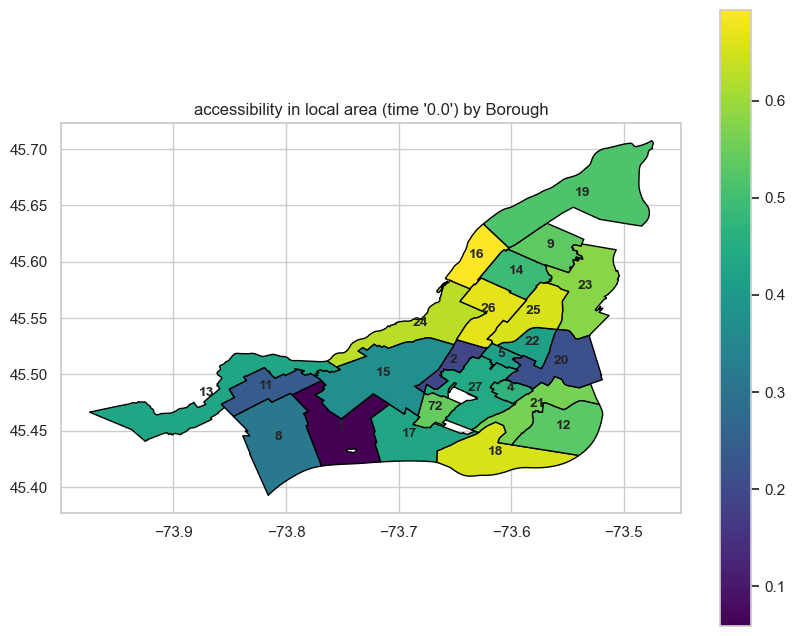

In [22]:
# Function to convert hex-encoded WKB to a shapely geometry object
def convert_wkb(hex_str):
    return wkb.loads(bytes.fromhex(hex_str))

# --- Assume df is your DataFrame as shown above ---

# # 1. Convert the 'geometry' column from WKB hex to shapely geometries
# results_geometry['geometry'] = results_geometry['geometry'].apply(convert_wkb)

# 2. Create a new column 'popGrowth' that extracts the value for time "0.0"
results_geometry['results'] = results_geometry['accessibilityOfHealthyFoodInLocalArea'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)

# 3. Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(results_geometry, geometry='geometry')

# 4. Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='results', ax=ax, legend=True, cmap='viridis', edgecolor='black')

# 5. Annotate each feature with its NUM value at the centroid of its geometry
for idx, row in gdf.iterrows():
    # Compute the centroid coordinates
    centroid = row['geometry'].centroid
    ax.annotate(text=str(row['NUM']), xy=(centroid.x, centroid.y),
                horizontalalignment='center', fontsize=10, fontweight='bold')

plt.title("accessibility in local area (time '0.0') by Borough")

# Save the plot as a PNG file
plt.savefig('Figures/accessibilityOfHealthyFoodInLocalArea_map.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
results_geometry['Local_area'] = results_geometry['localArea'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['Residential_area'] = results_geometry['residentialArea'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)

results_geometry['Prop_Household'] = results_geometry['householdTypeRisk'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['Prop_Housing'] = results_geometry['housingSituationRisk'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['Prop_Immi'] = results_geometry['immigrationStatusRisk'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['FIR_Reg'] = results_geometry['householdFoodInsecuritySimple'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['FIR_model'] = results_geometry['householdFoodInsecurity'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)

results_geometry['food_budget'] = results_geometry['insufficientFoodBudget'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['cost_of_living'] = results_geometry['costOfLiving'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['accessibility'] = results_geometry['accessibilityOfHealthyFoodInLocalArea'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['availability'] = results_geometry['availabilityOfHealthyFoodInLocalArea'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['availability_in_household'] = results_geometry['availabilityOfHealthyFoodInHousehold'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)

results_geometry['Census_TotalHouseholdTypes'] = results_geometry['initialTotalHouseholdTypes'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['Census_CoupleWithoutChildren'] = results_geometry['initialCoupleWithoutChildren'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['Census_TwoParent'] = results_geometry['initialTwoParent'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['Census_SingleParent'] = results_geometry['initialSingleParent'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['Census_Multigenerational'] = results_geometry['initialMultigenerational'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
results_geometry['Census_SinglePersonLivingAlone'] = results_geometry['initialSinglePersonLivingAlone'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)



Simulation_results = results_geometry[['NUM', 'Local_area', 'Residential_area', 'Prop_Household', 'Prop_Housing', 'Prop_Immi', 'FIR_Reg', 'FIR_model',
                                      'food_budget', 'cost_of_living', 'accessibility', 'availability', 'availability_in_household',
                                      'Census_TotalHouseholdTypes', 'Census_CoupleWithoutChildren', 'Census_TwoParent',
                                      'Census_SingleParent', 'Census_Multigenerational', 'Census_SinglePersonLivingAlone']]

# Save the DataFrame to an Excel file
Simulation_results.to_excel('Simulation_results_FIR.xlsx', index=False)
Simulation_results.head(5)

,NUM,Local_area,Residential_area,Prop_Household,Prop_Housing,Prop_Immi,FIR_Reg,FIR_model,food_budget,cost_of_living,accessibility,availability,availability_in_household,Census_TotalHouseholdTypes,Census_CoupleWithoutChildren,Census_TwoParent,Census_SingleParent,Census_Multigenerational,Census_SinglePersonLivingAlone
0,24,24.300744,14.920857,0.013437,0.044056,0.049088,0.111284,0.202010,0.068518,0.213535,0.628931,0.351861,0.343527,60820.939040,10604.728564,14133.338049,6018.402733,872.524369,25595.877267
1,9,13.761353,4.315678,0.013684,0.041632,0.091195,0.151213,0.223966,0.050189,0.186436,0.535540,0.281200,0.311621,18748.563326,3761.731054,4505.976240,1997.912354,325.518049,7006.489215
2,72,6.809135,3.984467,0.014201,0.039342,0.116978,0.175223,0.250131,0.188870,0.326730,0.544365,0.288077,0.320436,14208.055705,3246.154643,3671.252239,1264.008121,208.588771,5169.985729
3,27,21.490402,12.054044,0.012395,0.052748,0.051949,0.121794,0.230555,0.132483,0.282116,0.442825,0.208681,0.289381,78376.302745,12603.152602,16280.323889,7567.090920,909.737947,32431.874338
4,1,20.845387,4.934729,0.013550,0.030647,0.153755,0.202654,0.263725,0.050571,0.187059,0.059021,0.007632,0.250774,8705.796653,1977.517864,2054.251892,789.647837,144.884906,3310.169071


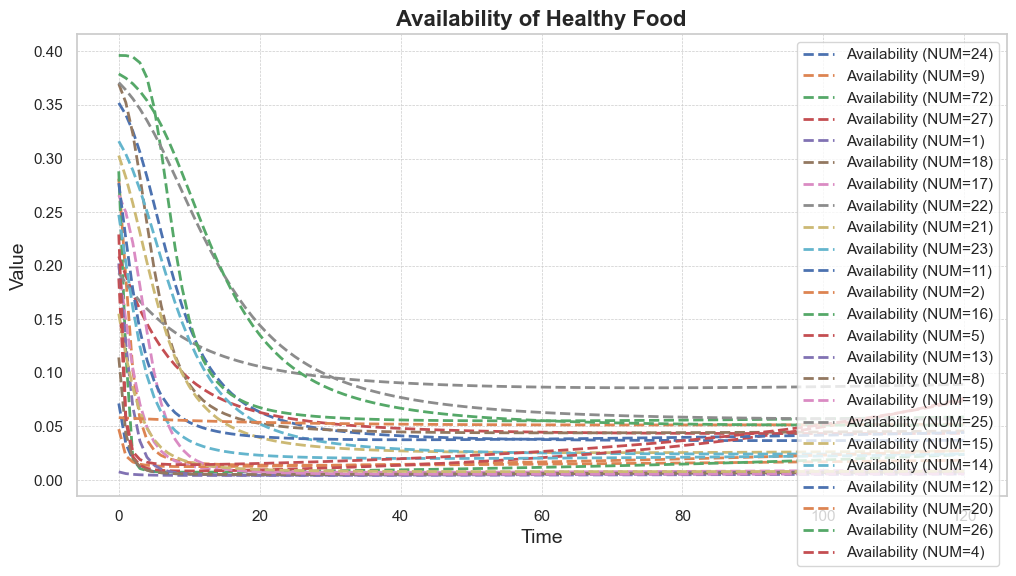

In [24]:
# Use seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Loop over each row in the DataFrame, where each row corresponds to a different NUM
for idx, row in df.iterrows():
    NUM_val = row['NUM']
    
    # Convert the JSON output for availability into a DataFrame and reset the index
    df_availability = pd.DataFrame.from_dict(
        pd.json_normalize(row['availabilityOfHealthyFoodInLocalArea']),
        orient='columns'
    ).T.reset_index(drop=True)
    
    # Plot the availability time series for this NUM.
    plt.plot(
        df_availability.index, 
        df_availability.values.flatten(), 
        label=f'Availability (NUM={NUM_val})',
        linestyle='--', 
        linewidth=2
    )

# Set x-axis ticks; adjust the step if needed.
plt.xticks(ticks=range(0, len(df_availability.index), 20))
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Availability of Healthy Food', fontsize=16, weight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a PNG file
plt.savefig('Figures/availability_only.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


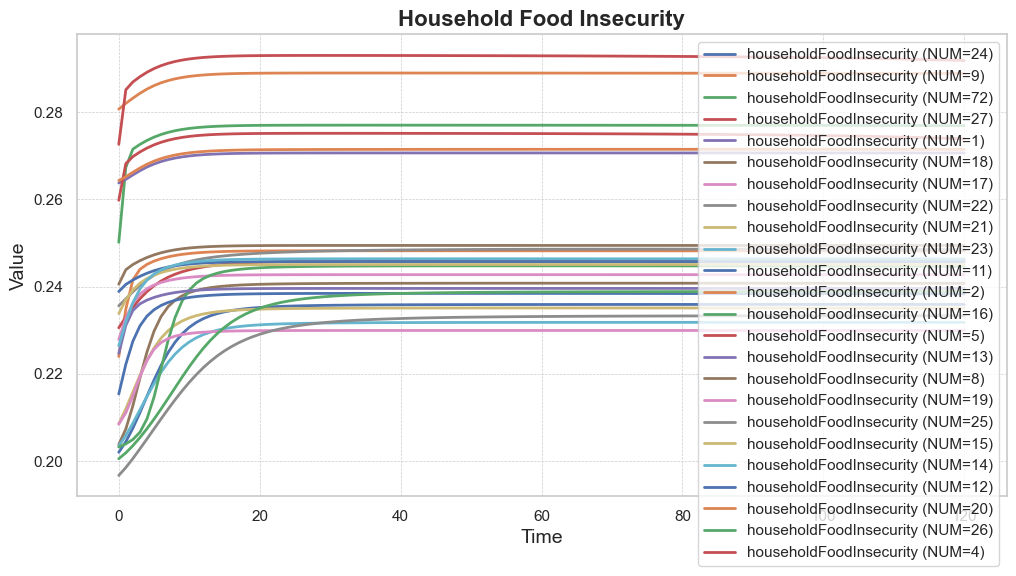

In [25]:
# Use seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Loop over each row in the DataFrame, where each row corresponds to a different NUM
for idx, row in df.iterrows():
    NUM_val = row['NUM']
    
    # Convert the JSON output for accessibility into a DataFrame and reset the index
    df_householdFoodInsecurity = pd.DataFrame.from_dict(
        pd.json_normalize(row['householdFoodInsecurity']), 
        orient='columns'
    ).T.reset_index(drop=True)
    
    # Plot the householdFoodInsecurity time series for this NUM.
    plt.plot(
        df_householdFoodInsecurity.index, 
        df_householdFoodInsecurity.values.flatten(), 
        label=f'householdFoodInsecurity (NUM={NUM_val})',
        linestyle='-', 
        linewidth=2
    )

# Set x-axis ticks; adjust the step if needed.
plt.xticks(ticks=range(0, len(df_accessibility.index), 20))
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Household Food Insecurity', fontsize=16, weight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a PNG file
plt.savefig('Figures/householdFoodInsecurity_only.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
